# Canvas Widget for IPython Notebook

In [1]:
from __future__ import print_function, unicode_literals, division

# The story

- Objective:
    - display images from numpy arrays
    - Handle JS mouse events in Python
    - Independent support for canvas size and display size
    - support canvas transform

- Canvas example using HTML and image at URL
- 

## HTML5 Canvas Element

The [Interactive Widgets](http://nbviewer.ipython.org/github/ipython/ipython/tree/3.x/examples/Interactive%20Widgets) for the [IPython Notebook](http://ipython.org/ipython-doc/dev/notebook/index.html) have tremendous potential for interesting interactive work.  I thought it would be a great learning experience to build a quantitative image viewing/analysis tool using these new widgets.  It turns out the IPython Notebook built-in image widget is based on an `<img>` element and is rather simple.  I decided that the first step on my new project would be to build a better image-display widget based on the awesome HTML5 Canvas Element.  The people at Mozilla have a nice [description](https://developer.mozilla.org/en-US/docs/Web/HTML/Element/canvas) of the `Canvas`.  Essentially, the Canvas Element is a great tool for displaying images and drawing artwork onto a bitmap surface.  It has built-in support for size and rotation transforms, and good number of third-party JavaScript libraries have sprung up adding all kinds of amazing feature.

While the `Canvas Element` can also be used for drawing lines and shapes, right now I'm completely focused on displaying and working with images.  I wrote the Canvas Widget generic enough such that adding additional draw functions should be a straightforward task.

There are many options to choose when using the `Canvas` to [display an image](https://developer.mozilla.org/en-US/docs/Web/Guide/HTML/Canvas_tutorial/Using_images).  It pretty much comes down to specifying a source of image data when calling `canvas.drawImage(some_image_data)`.  The [Canvas Tutorial](https://developer.mozilla.org/en-US/docs/Web/Guide/HTML/Canvas_tutorial/Using_images#Getting_images_to_draw) at the Mozilla Developer Network site has a good summary about which data types the `Canvas` can accept:

- **[HTMLImageElement](https://developer.mozilla.org/en-US/docs/Web/API/HTMLImageElement)**: These are images created using the `Image()` constructor, as well as any existing `<img>` [element](https://developer.mozilla.org/en-US/docs/Web/HTML/Element/img).

- **[HTMLVideoElement](https://developer.mozilla.org/en-US/docs/Web/API/HTMLVideoElement)**: Using an HTML [Video](https://developer.mozilla.org/en-US/docs/Web/HTML/Element/video) element as a source grabs the current frame from the video as the image.

- **[HTMLCanvasElement](https://developer.mozilla.org/en-US/docs/Web/API/HTMLCanvasElement)**: Another [Canvas](https://developer.mozilla.org/en-US/docs/Web/HTML/Element/canvas) element as a source.

The simplest option for me was to construct an internal `Image` element from appropriately-formatted image data.

### Canvas Example with HTML and JavaScript

The example below shows using a `Canvas` element to display an image and then giving it a nice black border.

In [3]:
%%html

<canvas id='hello_example' style='border: solid black 2px'/>

<script>
    // An elephant image URL
    var url = 'http://upload.wikimedia.org/wikipedia/commons/thumb/3/37/African_Bush_Elephant.jpg/160px-African_Bush_Elephant.jpg'

    // Get the canvas element plus corresponding drawing context
    var canvas = document.getElementById('hello_example');
    var context = canvas.getContext('2d');

    // Create a hidden <img> element to manage incoming data.
    var img = new Image();   

    // Add new-data event handler to the hidden <img> element.
    img.onload = function() {
        // This function will be called when new image data has finished loading
        // into the <img> element.  This new data will be the source for drawing
        // onto the Canvas.

        // Set canvas geometry.
        canvahttps://github.com/ipython/ipython/wiki/widgetss.width = img.width
        canvas.style.width = img.width + 'px'

        canvas.height = img.height
        canvas.style.height = img.height + 'px'

        // Draw new image data onto the Canvas.
        context.drawImage(img, 0, 0);
    }

    // Assign image URL.
    img.src = url
    
</script>

Hey look!  That's a neat elephant.

## My new Class: `CanvasImage`

Have a look at the JavaScript source code for the `CanvasWidget` I wrote based on the IPython Notebook's widget infrastructure.

You'll see components similar to the example just above at the core of my widget.  The full version is more complicated due to it being implemented as part of an existing framework that itself is a sophisticated mix of multiple JavaScript libraries (but mostly BackboneJS in this context).

In the next cell I use my new Canvas Image Widget to load and display the same image as above, except this time it's so much simpler.

In [2]:
import requests
import IPython.html.widgets
from widget_canvas import image

import matplotlib.pyplot as plt

%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [4]:
url_elephant = 'http://upload.wikimedia.org/wikipedia/commons/thumb/3/37/African_Bush_Elephant.jpg/160px-African_Bush_Elephant.jpg'

resp = requests.get(url_elephant)

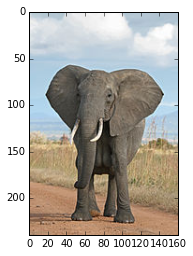

In [8]:
d = image.decompress(resp.content)

plt.imshow(d)
plt.show()

In [9]:
# Same URL as earlier
url_elephant = 'http://upload.wikimedia.org/wikipedia/commons/thumb/3/37/African_Bush_Elephant.jpg/160px-African_Bush_Elephant.jpg'

# Make the widget and display it to the screen.
wid = widget_canvas.CanvasImage()
wid.data_encode = url_elephant
# wid.display()

NameError: name 'widget_canvas' is not defined

In [8]:
wid.display()

In [9]:
wid.display()
print(wid.width, wid.height)

160.0 240.0


But what about the nice black line around the edge?  No problem!  The IPython built-in Widget's support direct manipulation of CSS properties.  My Canvas Widget is an extension of the IPython `DOMWidget`, so it too can manipulate CSS properties.  The Mozilla Develloper Network has great reference information for [CSS properties](https://developer.mozilla.org/en-US/docs/Web/CSS/Reference).


In [10]:
# Update widget's image border property.
wid.set_css('border', 'solid black 2px')

# There we go!  So really just a few lines of Python code.

Using my `CanvasImageWidget` is much easier than stepping through all those hoops needed with the `%%html` or `%%javascript` magic functions.  And that's the whole point of the IPython Notebook!  Make it easier to work with data and view the results.

## What about the Custom JavaScript Source Code?

Most of the Notebook JavaScript extensions and examples I've seen place new JavaScript code in the user's  IPython profile `static/custom` folder.  That just seems a bit cumbersome to me so I tried something different for this project.  I include a `js` subfolder inside my Python package and I wrote a couple of helper Python functions.  When a `CanvasWidget` is instantiated it calls the function `_bootstrap_js()` which reads in any required JavaScript files.  The contents of each file are then injected into the Notebook using IPython's built-in `display_javascript()` function.

```Python
_path_module = os.path.abspath(os.path.dirname(__file__))
_path_js = os.path.join(_path_module, 'js')

def _read_local_js(fname):
    """Read a JavaScript file from application's local JS folder.  Return a string."""
    b, e = os.path.splitext(os.path.basename(fname))
    f = os.path.join(_path_js, b + '.js')

    with open(f) as fo:
        return fo.read()


def _bootstrap_js():
    """Load JavaScript and inject into current Notebook session."""
    files = ['widget_canvas.js']
    for f in files:
        js = _read_local_js(f)
        IPython.display.display_javascript(js, raw=True)
```

## Display Images from Numpy Arrays

While displaying images by specifying a URL has many uses, I'm mostly interested in displaying technical imagery as part of my everyday data analysis efforts.  This means working with data in Numpy arrays in the Python back-end and somehow transfering images to the JavaScript front-end in a manner compatible with the existing Widget system.  It turns out it's quite easy to compress an image as PNG and embed that data via [Base64](http://en.wikipedia.org/wiki/Base64) encoding into a very large URL string.  This may not be the most efficient or elegant solution, but it was simplest for me to understand and get it working quickly.  

The little helper function below shows how I do this conversion, using `PIL/Pillow` behind the scenes to perform the actual PNG compression.  The input to the helper function is a Numpy array containing an image, and the output is a huge URL string with embedded image data.

In [11]:
import base64

def encode_src_data(image):
    """
    Compress and encode input image data.
    Format as <img> element src string with embedded data.
    This function uses a PNG compression function from the included module image.py.
    """
    # Compress with PNG.
    data_comp, fmt = canvas.image.compress(image)

    # Encode with base64.
    data_b64 = base64.b64encode(data_comp)

    # Build an Image Element src string with embedded data.
    data_encode = 'data:image/{:s};base64,{:s}'.format(fmt, data_b64)
    
    return data_encode

## Using `CanvasImage` with Embedded Data 

Here is a quick example of what that encoded URL looks like:

In [12]:
# Load image file using my simple image reader helper function.
data_whippet = canvas.image.read('images/Whippet.jpg')

print('\nImage shape: {}'.format(data_whippet.shape))

# Encode all test images into src 
src_image = encode_src_data(data_whippet)

print('\nURL number of characters: {:d}'.format(len(src_image)))
print('\nURL first 200 characters: "{:s}..."'.format(src_image[:200]))


Image shape: (220, 320, 3)

URL number of characters: 108638

URL first 200 characters: "data:image/PNG;base64,iVBORw0KGgoAAAANSUhEUgAAAUAAAADcCAIAAACOIe9xAAEAAElEQVR4nOT9a4xsSXoYiH2PiDjnZGbVffa7Z3qGwxmSGlIUibVE07sUsFgLlgwYsmCs4cViARtY+/fCMAx44f8GDPuPDNjwX/9dSzbWgi3J0EKAbYna9ZJLkZTI5kxPd0..."


This large `src` string with the embedded photo may be fed directly into a `CanvasImageWidget`.

In [13]:
# Create a CanvasWidget using image data embedded in URL string.
wid = canvas.CanvasImageBase()

wid.data_encode = src_image

wid.display()

I wrote my `CanvasImage` class such that it can directly accept Numpy arrays containing image data and incorporates the above functionality as integral components.  This class handles all the details for embedding the compressed image into the Canvas Element.

In [16]:
# Load another dog image.
data_doberman = canvas.image.read('images/Doberman.jpg')

# Display Numpy image directly.
wid = canvas.CanvasImageBase(data_doberman)
wid.display()

But which dog to choose?  I like them both!

In [34]:
import time
num_loop = 100
dt = 0.05

t0 = time.time()
for k in range(num_loop):
    wid.image = [data_whippet, data_doberman][k % 2]
    time.sleep(dt)
    
t1 = time.time()

fps = num_loop / (t1 - t0)
print('Rate: {:5.2f} FPS'.format(fps))

Rate: 13.97 FPS


## Final Thoughts

The `CanvasImage` does not currently support drawing geometric shapes, but I'm certain it could be done without too much effort.  My focus now is with image display, but that doesn't prevent anyone else from lending a hand and working out details for line and shape drawing. The next step for me will be to add basic support for mouse and keyboard events such that the user will be able to attach their own Python event handlers.  I also want to support image [transforms](http://www.whatwg.org/specs/web-apps/current-work/multipage/the-canvas-element.html#transformations).  The next steps will be to provide helper functions making it easy to connect mouse/keyboard events with generating new image transforms.  This combination will enable even more features like image panning with the mouse or zooming with the scroll wheel.  

**Yeah!  I can't wait!**